In [3]:
import pandas as pd
import tweepy as tw
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
nltk.download('punkt')
import re
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from afinn import Afinn
import matplotlib.pyplot as plt
import gensim
from gensim import corpora


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Blake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Blake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
consumer_key= '******************'
consumer_secret= '**********************'
access_token= '*********************'
access_token_secret= '*****************'

In [5]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [6]:
def get_tweets(text, since_date, count):
    search_term = str(text+"-filter:retweets")
    tweets = tw.Cursor(api.search, q=search_term, lang="en", since=since_date).items(count)
    all_tweets = [tweet.text for tweet in tweets]
    #all_tweets = pd.DataFrame(all_tweets)
    return all_tweets

In [7]:
spx_tweets = get_tweets('SPX','2019-01-01',1000)


In [9]:
#preprocessing
tweets = pd.DataFrame(spx_tweets)
tweets.head()

,0
0,$SPX Max Pain=2850.00. Maturity=05/17/2019. #m...
1,1/ Globex Thoughts -- The drop ~ 8pm EST act...
2,The Fatty Momentum is when the DELTA and the P...
3,Indexes failed to recapture their 50dma today....
4,Still thinking that the trade war isn’t the ca...


In [10]:
lmtzr = WordNetLemmatizer()


In [11]:
X = tweets.astype(str)
X.columns = ['tweet']

In [12]:
#remove stopwords
stop = stopwords.words('english') #type stop to see your stopwords in a list
X.tweet = X.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
X = X.tweet
X.tail()

995    If think market already bottomed, think tradin...
996    April NFIB small business optimism index rose ...
997    @kyee I it, intrigued. Here overlay $GBTC &amp...
998    $SPX sharp reversal $AMZN takes #15ORB down......
999    US indices... #SPX, #NDX, #RUT... far failure ...
Name: tweet, dtype: object

In [13]:
#create a list of all tweets (our corpus)
documents = []

for sen in range(0, len(X)):
    # remove twitter handle
    document = re.sub('@[^\s]+', '', str(X[sen]))  # X[sen] first because loop

    # remove any urls
    document = re.sub(r"http\S+", "", document)

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization - converting words with ing/es/ed to their main word
    document = document.split()
    document = [lmtzr.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append(document)


In [14]:
tweet_df = pd.DataFrame(X)
tweet_df['clean_tweet'] = documents
tweet_df.head()

,tweet,clean_tweet
0,$SPX Max Pain=2850.00. Maturity=05/17/2019. #m...,spx max pain 2850 00 maturity 05 17 2019 maxpa...
1,1/ Globex Thoughts -- The drop ~ 8pm EST actua...,1 globex thought the drop 8pm est actually res...
2,The Fatty Momentum DELTA Pace Trade show buyer...,the fatty momentum delta pace trade show buyer...
3,Indexes failed recapture 50dma today. Ugly rej...,index failed recapture 50dma today ugly reject...
4,Still thinking trade war isn’t catalyst next b...,still thinking trade war isn catalyst next bea...


In [17]:
#sentiment analysis
af = Afinn()

sentiment_scores = [af.score(tweet) for tweet in documents]
sentiment_category = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in sentiment_scores]

tweet_df['sentiment'] = sentiment_scores
tweet_df['sentiment_cat'] = sentiment_category
tweet_df.head()

,tweet,clean_tweet,sentiment,sentiment_cat
0,$SPX Max Pain=2850.00. Maturity=05/17/2019. #m...,spx max pain 2850 00 maturity 05 17 2019 maxpa...,-2.0,negative
1,1/ Globex Thoughts -- The drop ~ 8pm EST actua...,1 globex thought the drop 8pm est actually res...,-1.0,negative
2,The Fatty Momentum DELTA Pace Trade show buyer...,the fatty momentum delta pace trade show buyer...,0.0,neutral
3,Indexes failed recapture 50dma today. Ugly rej...,index failed recapture 50dma today ugly reject...,-7.0,negative
4,Still thinking trade war isn’t catalyst next b...,still thinking trade war isn catalyst next bea...,-2.0,negative


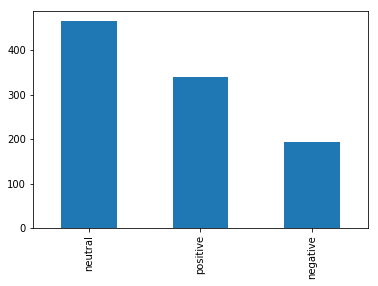

In [18]:
tweet_df['sentiment_cat'].value_counts().plot(kind='bar')


In [19]:
overall_sentiment = tweet_df.sentiment.sum()
overall_sentiment

435.0

In [20]:
#topic modelling
docs_split = []
for sen in range(0, len(documents)):
    document = documents[sen].split()
    docs_split.append(document)



In [21]:
dictionary = corpora.Dictionary(docs_split)
corpus = [dictionary.doc2bow(text) for text in docs_split]

In [22]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

In [23]:
topics = ldamodel.print_topics(num_words=5)


In [24]:
for topic in topics:
    print(topic)

(0, '0.067*"spx" + 0.023*"spy" + 0.020*"es_f" + 0.016*"today" + 0.014*"day"')
(1, '0.051*"spx" + 0.013*"stock" + 0.012*"spy" + 0.009*"day" + 0.008*"market"')
(2, '0.048*"spx" + 0.015*"day" + 0.009*"daily" + 0.008*"open" + 0.007*"stock"')
(3, '0.027*"spx" + 0.007*"2" + 0.007*"trading" + 0.007*"market" + 0.007*"e"')
(4, '0.028*"spx" + 0.019*"chart" + 0.010*"see" + 0.010*"the" + 0.008*"day"')
(5, '0.050*"spx" + 0.011*"stock" + 0.011*"bounce" + 0.010*"trade" + 0.010*"spy"')
(6, '0.039*"spx" + 0.016*"spy" + 0.009*"market" + 0.009*"buy" + 0.007*"2"')
(7, '0.029*"spx" + 0.008*"the" + 0.007*"we" + 0.007*"point" + 0.006*"trading"')
(8, '0.065*"spx" + 0.028*"spy" + 0.016*"aapl" + 0.016*"rut" + 0.015*"qqq"')
(9, '0.046*"spx" + 0.018*"spy" + 0.014*"1" + 0.013*"buy" + 0.010*"est"')


In [25]:
model_topics = pd.DataFrame(topics)
topic_pred = []
for i in range(0,len(docs_split)):
    doc = dictionary.doc2bow(docs_split[i])
    pred = ldamodel.get_document_topics(doc)
    topic_pred.append(pred)

In [26]:
topic_df = pd.DataFrame(documents)
topic_df['topic'] = topic_pred
topic_df.head(15)
results = pd.merge(tweet_df, topic_df, how='inner', left_on = tweet_df.index, right_on=topic_df.index)
results

,key_0,tweet,clean_tweet,sentiment,sentiment_cat,0,topic
0,0,$SPX Max Pain=2850.00. Maturity=05/17/2019. #m...,spx max pain 2850 00 maturity 05 17 2019 maxpa...,-2.0,negative,spx max pain 2850 00 maturity 05 17 2019 maxpa...,"[(9, 0.9249934)]"
1,1,1/ Globex Thoughts -- The drop ~ 8pm EST actua...,1 globex thought the drop 8pm est actually res...,-1.0,negative,1 globex thought the drop 8pm est actually res...,"[(4, 0.9356971)]"
2,2,The Fatty Momentum DELTA Pace Trade show buyer...,the fatty momentum delta pace trade show buyer...,0.0,neutral,the fatty momentum delta pace trade show buyer...,"[(1, 0.91814584)]"
3,3,Indexes failed recapture 50dma today. Ugly rej...,index failed recapture 50dma today ugly reject...,-7.0,negative,index failed recapture 50dma today ugly reject...,"[(5, 0.94373477)]"
4,4,Still thinking trade war isn’t catalyst next b...,still thinking trade war isn catalyst next bea...,-2.0,negative,still thinking trade war isn catalyst next bea...,"[(8, 0.9181527)]"
5,5,Which came first? Chicken egg? Technicals news...,which came first chicken egg technical news th...,0.0,neutral,which came first chicken egg technical news th...,"[(7, 0.9356996)]"
6,6,"May 14 #commodities ags %-chg, Jul beans #ZS_F...",may 14 commodity ag chg jul bean zs_f 3 6 jul ...,0.0,neutral,may 14 commodity ag chg jul bean zs_f 3 6 jul ...,"[(1, 0.9624875)]"
7,7,"May 14 #commodities heavies %-chg, #bloomberg ...",may 14 commodity heavy chg bloomberg index 1 2...,2.0,positive,may 14 commodity heavy chg bloomberg index 1 2...,"[(6, 0.95908207)]"
8,8,Nervous one I often bottle it. Really trying f...,nervous one often bottle it really trying focu...,-2.0,negative,nervous one often bottle it really trying focu...,"[(7, 0.9249797)]"
9,9,$SPX: The Margin: This Monet painting’s return...,spx the margin this monet painting return inve...,0.0,neutral,spx the margin this monet painting return inve...,"[(1, 0.93074286)]"
